In [39]:
## Naver 웹툰 크롤링해서 장르에 따른 조회수,좋아요로 인기분석?해서 시각화
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import time 
import re

driver = webdriver.Chrome()
    
## url
url = 'https://comic.naver.com/webtoon?tab='

day = ['mon','tue','wed','thu','fri','sat','sun']

# df 만들 빈 배열 생성
webtoon = []

# 요일별 웹툰 나눠서 해당 요일별 웹툰 보이게 하기
for i in day:   
     response = driver.get(url+i)    
     time.sleep(1)
     soup = BeautifulSoup(driver.page_source,'html.parser')
     links = soup.select('.ContentList__content_list--q5KXY>li.item')
     # 링크를 선택할 CSS 선택자로 수정

     for link in links:
         
         # 제목 , 작가 , 별점 가져오기
          title = link.select_one('.ContentTitle__title--e3qXt>.text').text
          writer = link.select_one('.ContentAuthor__author--CTAAP').text
          score = link.select_one('.Rating__star_area--dFzsb>.text').text
         
          
          # 웹툰 상세페이지 들어가기
          link_url = link.select_one('a',href=True)['href']
          detail_url = 'https://comic.naver.com'
          response = driver.get(detail_url + link_url)
          time.sleep(2)
          soup = BeautifulSoup(driver.page_source,'html.parser')
          
          # 장르별 해시태그 가져오기
          lists = soup.select('.EpisodeListInfo__summary_wrap--ZWNW5>div.EpisodeListInfo__tag_area--BRk5c ')
          # 태그 넣어줄 빈배열 만들기
          genre = []
          for li in lists:
               tags = li.select('.TagGroup__tag_group--uUJza>a.TagGroup__tag--xu0OH')
               
               # 반복문 활용해서 tags list에 저장된 태그를 정규표현식을 활용하여 #'단어' 를 가지고 옴
               for tag in tags:
                    tag_text = tag.text
                    tag1 = re.findall(r'#(\w+)', tag_text)
                    # 태그가 여러 개인 경우 리스트를 만들어 저장
                    for i in tag1:
                         genre.append(i)  

          
          # 관심 수 가져오기
          inters = soup.select('.EpisodeListUser__count--fNEWK')
          
          # 정규 표현식 활용해서 태그에 싸져있는 텍스트 가져오기
          for num in inters:     
               num_text = num.text
               number = re.sub(r'[^0-9,]', '', num_text)
            
          
     
          webtoon.append([title, writer,score,genre,number])
          #print(webtoon)

# dataframe으로 변형
df = pd.DataFrame(webtoon, columns=['제목','작가','평점','장르','관심(알림설정) 수'])

# 웹툰 중복 없애기(webtoon의 title이 이미 있으면 중복 제거)
if(df['제목'] is not None):
     df = df.drop_duplicates(subset='제목')

# csv파일 저장
df.to_csv('webtoon.info.csv',index=False,encoding='cp949')

TypeError: no numeric data to plot

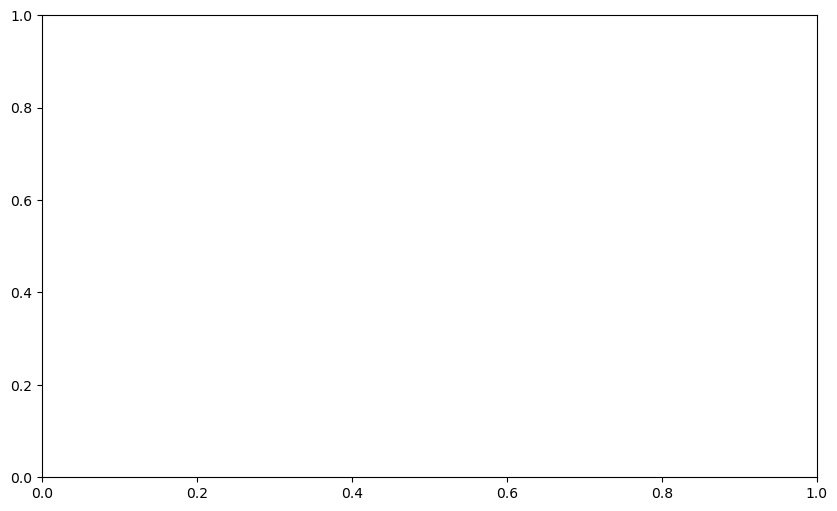

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('webtoon.info.csv', encoding='cp949')

dfWebtoon = df.copy()
#dfWebtoon.head(10)

# 장르별 관심(알림설정) 수 합계 계산
genre_views = dfWebtoon.groupby('장르')['관심(알림설정) 수'].sum()

# 장르별 평점 수 평균 계산
genre_likes = dfWebtoon.groupby('장르')['평점'].mean()

# 장르별 조회수 시각화
plt.figure(figsize=(10, 6))
genre_views.plot(kind='bar')
plt.title('장르별 관심(알림설정 수)')
plt.xlabel('장르')
plt.ylabel('관심(알림설정 수)')
plt.xticks(rotation=45)
plt.show()

# 장르별 평균 별점 시각화
plt.figure(figsize=(10, 6))
genre_likes.plot(kind='bar')
plt.title('장르별 별점')
plt.xlabel('장르')
plt.ylabel('평균 별점')
plt.xticks(rotation=45)
plt.show()